In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Conv1D, MaxPooling1D, Flatten, Add, ReLU
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from imblearn.over_sampling import SMOTE

from sklearn.metrics import accuracy_score, classification_report

from imblearn.over_sampling import SMOTE, RandomOverSampler

from pathlib import Path
import re 

import pickle
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
print(tf.config.list_physical_devices('GPU'))  # should show []
from contextlib import redirect_stdout
import json
from collections import Counter

from src.visualization.visualization import plot_training_history

2025-10-30 21:11:26.778548: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-30 21:11:26.828612: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-30 21:11:28.340374: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


[]


2025-10-30 21:11:29.147510: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [2]:
SAMPLING_METHOD = "SMOTE"
REMOVE_OUTLIERS = False
OUTPUT_PATH = "src/models/CNN/"
results_csv = "reports/03_model_testing_results/05_CNN_model_comparison.csv"
EPOCHS = 50
BATCH_SIZE = 128
models = {"cnn1_sm": {}, "cnn2_sm": {}, "cnn3_sm": {}, "cnn4_sm": {}, 'cnn5_sm': {}}
model_names = list(models.keys())

#import MIT data
df_mitbih_test = pd.read_csv('data/original/mitbih_test.csv', header = None)

X_train = pd.read_csv('data/processed/mitbih/X_train.csv')
y_train = pd.read_csv('data/processed/mitbih/y_train.csv')
y_train = y_train['187']

X_val = pd.read_csv('data/processed/mitbih/X_val.csv')
y_val = pd.read_csv('data/processed/mitbih/y_val.csv')
y_val = y_val['187']

X_test = df_mitbih_test.drop(187, axis = 1)
y_test = df_mitbih_test[187]


# Apply SMOTE
# --- Before SMOTE ---
print("Before SMOTE:", Counter(y_train))

# Convert to numpy if not already
X_train_np = np.array(X_train)
y_train_np = np.array(y_train)

# --- Apply SMOTE ---
sm = SMOTE(random_state=42, sampling_strategy='auto', k_neighbors=5)
X_train_sm, y_train_sm = sm.fit_resample(X_train_np, y_train_np)

print("After SMOTE:", Counter(y_train_sm))
print("X_train_sm shape:", X_train_sm.shape)

# Reshape the data for 1D CNN
#X_train_sm_cnn = np.expand_dims(X_train_sm, axis=2)
X_train_sm_cnn = np.expand_dims(X_train_sm, axis=2)
X_train_cnn = np.expand_dims(X_train, axis=2)
X_val_cnn = np.expand_dims(X_val, axis=2)
X_test_cnn = np.expand_dims(X_test, axis=2) 

display(X_train_cnn.shape)
display(X_val_cnn.shape)
display(X_test_cnn.shape)

def parse_epoch_from_name(name, default_epochs=EPOCHS):
    # Expect pattern like ..._epoch_12_...; returns int if found else default
    m = re.search(r"epoch_(\d+)", name)
    return int(m.group(1)) if m else default_epochs

def parse_val_loss_from_name(name):
    # Expect pattern like ..._valloss_0.1234.keras
    m = re.search(r"valloss_([0-9]+\.[0-9]+)", name)
    return float(m.group(1)) if m else np.nan

Before SMOTE: Counter({0.0: 57977, 4.0: 5145, 2.0: 4630, 1.0: 1778, 3.0: 513})
After SMOTE: Counter({np.float64(0.0): 57977, np.float64(4.0): 57977, np.float64(2.0): 57977, np.float64(1.0): 57977, np.float64(3.0): 57977})
X_train_sm shape: (289885, 187)


(70043, 187, 1)

(17511, 187, 1)

(21892, 187, 1)

| Model | Layers           | BatchNorm | Dropout     | Notes                          |
| ----- | ---------------- | --------- | ----------- | ------------------------------ |
| CNN1  | 3 Conv + 2 Dense | ✅         | ✅ (0.3–0.4) | Deep, balanced regularization  |
| CNN2  | 4 Conv + 1 Dense | ❌         | ❌           | Baseline paper model           |
| CNN3  | 4 Conv + 1 Dense | ✅         | ✅ (0.4)     | Regularized version of CNN2    |
| CNN4  | 4 Conv + 1 Dense | ✅         | ✅ (0.3)     | More dropout across all layers |
| CNN5  | 2 Conv + 2 Dense | ❌         | ❌           | Simpler LeNet-style baseline   |


In [3]:
#Used CNNs

#CNN1
cnn1 = Sequential([
    Input((187, 1)),
    Conv1D(64, 5, activation='relu'), BatchNormalization(), MaxPooling1D(2), Dropout(0.3),
    Conv1D(128, 3, activation='relu'), BatchNormalization(), MaxPooling1D(2), Dropout(0.3),
    Conv1D(256, 3, activation='relu'), BatchNormalization(), MaxPooling1D(2), Dropout(0.3),
    Flatten(),
    Dense(128, activation='relu'), BatchNormalization(), Dropout(0.4),
    Dense(64, activation='relu'), BatchNormalization(), Dropout(0.4),
    Dense(5, activation='softmax')
])


#CNN2, CNN4 Paper 2020
cnn2 = Sequential([
    Input((187, 1)),
    Conv1D(32, 5, activation='relu'), MaxPooling1D(2),
    Conv1D(64, 3, activation='relu'), MaxPooling1D(2),
    Conv1D(128, 5, activation='relu'), MaxPooling1D(2),
    Conv1D(256, 3, activation='relu'), MaxPooling1D(2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(5, activation='softmax')
])


#CNN3, CNN4-2 Paper 2020, BatchNormalization and Dropout layers added
cnn3 = Sequential([
    Input((187, 1)),
    Conv1D(32, 5, activation='relu'), BatchNormalization(), MaxPooling1D(2),
    Conv1D(64, 3, activation='relu'), BatchNormalization(), MaxPooling1D(2),
    Conv1D(128, 5, activation='relu'), BatchNormalization(), MaxPooling1D(2),
    Conv1D(256, 3, activation='relu'), BatchNormalization(), MaxPooling1D(2),
    Flatten(),
    Dense(64, activation='relu'), BatchNormalization(), Dropout(0.4),
    Dense(5, activation='softmax')
])


#CNN4, CNN4-3 Paper 2020, more BatchNormalization and Dropout layers added
cnn4 = Sequential([
    Input((187, 1)),
    Conv1D(32, 5, activation='relu'), BatchNormalization(), MaxPooling1D(2), Dropout(0.3),
    Conv1D(64, 3, activation='relu'), BatchNormalization(), MaxPooling1D(2), Dropout(0.3),
    Conv1D(128, 5, activation='relu'), BatchNormalization(), MaxPooling1D(2), Dropout(0.3),
    Conv1D(256, 3, activation='relu'), BatchNormalization(), MaxPooling1D(2), Dropout(0.3),
    Flatten(),
    Dense(64, activation='relu'), BatchNormalization(), Dropout(0.3),
    Dense(5, activation='softmax')
])


#CNN5, LENET
cnn5 = Sequential([
    Input((187, 1)),
    Conv1D(32, 15, activation='relu'), MaxPooling1D(2),
    Conv1D(64, 16, activation='relu'), MaxPooling1D(2),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(5, activation='softmax')
])


In [4]:
models["cnn1_sm"]["model"] = cnn1
models["cnn2_sm"]["model"] = cnn2
models["cnn3_sm"]["model"] = cnn3
models["cnn4_sm"]["model"] = cnn4
models["cnn5_sm"]["model"] = cnn5

In [5]:
for model_name, model in models.items():
    print("*"*80)
    print("*"*5,'\t',model_name,'\t',"*"*5)
    print("*"*80)
    #reduce lr when plateau
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',  # Metric to monitor
        factor=0.1,          # Factor by which the learning rate will be reduced
        patience=5,          # Number of epochs with no improvement after which learning rate is reduced
        min_lr=1e-6,         # Minimum learning rate
        verbose=1           
    )
    cf = model["model"]

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=8,
        min_delta=1e-4,
        restore_best_weights=True,
        verbose=1
    )

    #Compile model, change model when needed
    cf.compile(loss="sparse_categorical_crossentropy",
                optimizer=Adam(learning_rate=1e-3),
                metrics=["accuracy"]) 


    #Define where and how to save the best model, note lr and bs
    checkpoint = ModelCheckpoint(
        filepath=f'{OUTPUT_PATH}{model_name}_BS{BATCH_SIZE}.keras',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        verbose=1
    )

    #Training
    history = cf.fit(                      
        X_train_sm_cnn,
        y_train_sm,
        epochs=EPOCHS,                              # change when needed
        batch_size=BATCH_SIZE,                      # change when needed
        validation_data=(X_val_cnn, y_val),         # unaltered validation set
        callbacks=[checkpoint, early_stopping]      # add here reduce_lr when needed
    )

    #Save training history
    with open(f"{OUTPUT_PATH}{model_name}_history.pkl", "wb") as f: #change for model
        pickle.dump(history, f)

    models[model_name]["history"] = history.history
    print("-"*80,'\n')

********************************************************************************
***** 	 cnn1_sm 	 *****
********************************************************************************
Epoch 1/50
2264/2265 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8493 - loss: 0.4343
Epoch 1: val_loss improved from None to 0.43318, saving model to src/models/CNN/cnn1_sm_BS128.keras
2265/2265 ━━━━━━━━━━━━━━━━━━━━ 121s 52ms/step - accuracy: 0.9097 - loss: 0.2617 - val_accuracy: 0.8650 - val_loss: 0.4332
Epoch 2/50
2264/2265 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9607 - loss: 0.1180
Epoch 2: val_loss improved from 0.43318 to 0.15325, saving model to src/models/CNN/cnn1_sm_BS128.keras
2265/2265 ━━━━━━━━━━━━━━━━━━━━ 114s 50ms/step - accuracy: 0.9645 - loss: 0.1061 - val_accuracy: 0.9482 - val_loss: 0.1532
Epoch 3/50
2264/2265 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9744 - loss: 0.0782
Epoch 3: val_loss improved from 0.15325 to 0.11412, saving model to src/models/CNN/cnn1_sm_BS128.ker

********************************************************************************
***** 	 cnn1_sm 	 *****
********************************************************************************
685/685 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
              precision    recall  f1-score   support

         0.0     0.9920    0.9912    0.9916     18118
         1.0     0.8114    0.8201    0.8157       556
         2.0     0.9620    0.9613    0.9617      1448
         3.0     0.7836    0.8272    0.8048       162
         4.0     0.9894    0.9900    0.9897      1608

    accuracy                         0.9836     21892
   macro avg     0.9077    0.9180    0.9127     21892
weighted avg     0.9837    0.9836    0.9837     21892

Predictions      0    1     2    3     4
187                                     
0.0          17959  102    32   17     8
1.0             88  456    11    0     1
2.0             25    3  1392   20     8
3.0             16    1    11  134     0
4.0             15    0     1    0  15

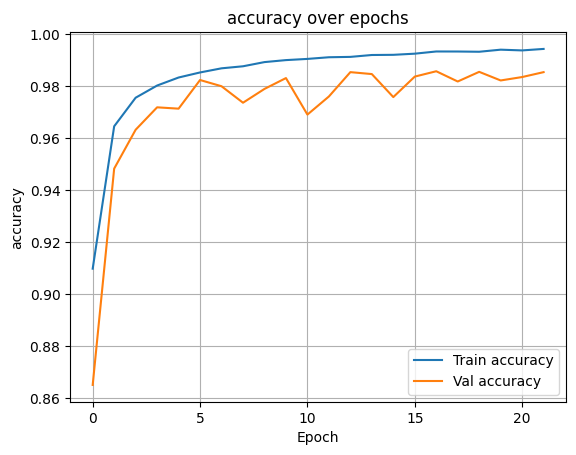

Saved: reports/figures/training_history/cnn1_sm_BS128_loss.png


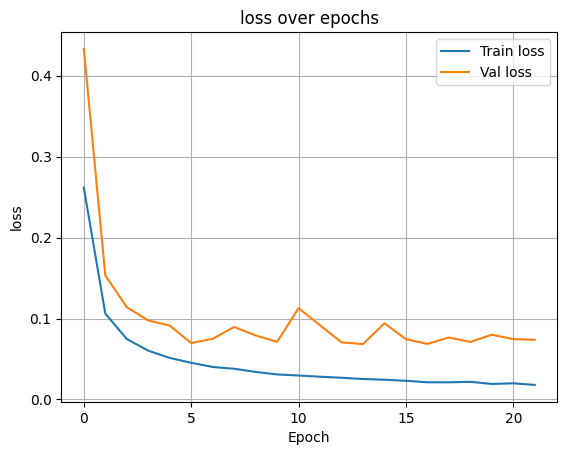

********************************************************************************
***** 	 cnn2_sm 	 *****
********************************************************************************
685/685 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

         0.0     0.9912    0.9868    0.9890     18118
         1.0     0.7804    0.8183    0.7989       556
         2.0     0.9359    0.9482    0.9420      1448
         3.0     0.7097    0.8148    0.7586       162
         4.0     0.9846    0.9913    0.9879      1608

    accuracy                         0.9790     21892
   macro avg     0.8804    0.9119    0.8953     21892
weighted avg     0.9796    0.9790    0.9793     21892

Predictions      0    1     2    3     4
187                                     
0.0          17878  120    67   34    19
1.0             89  455    10    1     1
2.0             44    7  1373   19     5
3.0             15    0    15  132     0
4.0             11    1     2    0  15

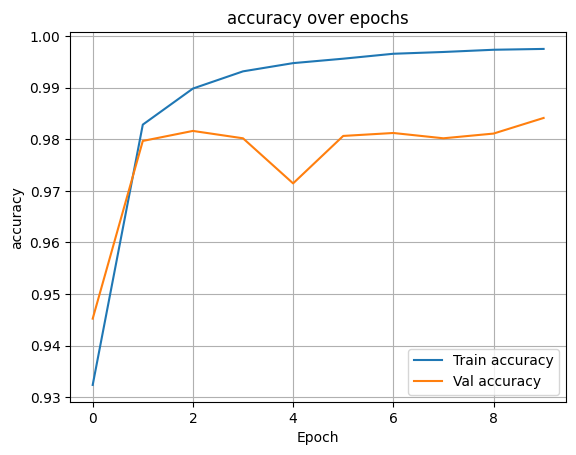

Saved: reports/figures/training_history/cnn2_sm_BS128_loss.png


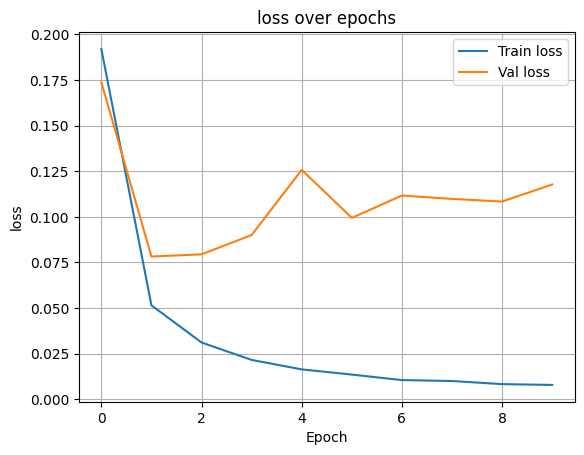

********************************************************************************
***** 	 cnn3_sm 	 *****
********************************************************************************
685/685 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
              precision    recall  f1-score   support

         0.0     0.9862    0.9922    0.9892     18118
         1.0     0.8088    0.7608    0.7841       556
         2.0     0.9788    0.9247    0.9510      1448
         3.0     0.7901    0.7901    0.7901       162
         4.0     0.9820    0.9838    0.9829      1608

    accuracy                         0.9797     21892
   macro avg     0.9092    0.8903    0.8995     21892
weighted avg     0.9794    0.9797    0.9795     21892

Predictions      0    1     2    3     4
187                                     
0.0          17976   93    23    8    18
1.0            127  423     2    1     3
2.0             70    7  1339   25     7
3.0             30    0     3  128     1
4.0             25    0     1    0  15

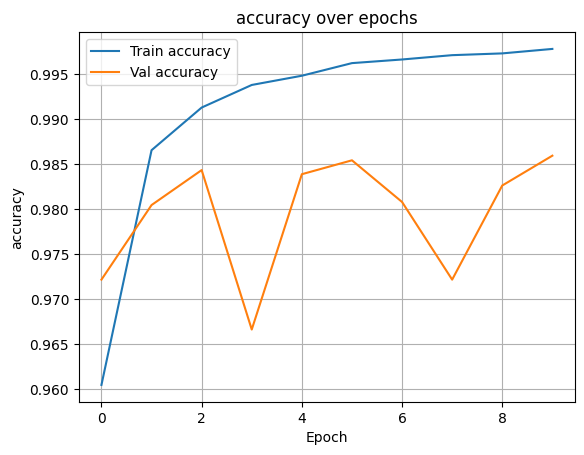

Saved: reports/figures/training_history/cnn3_sm_BS128_loss.png


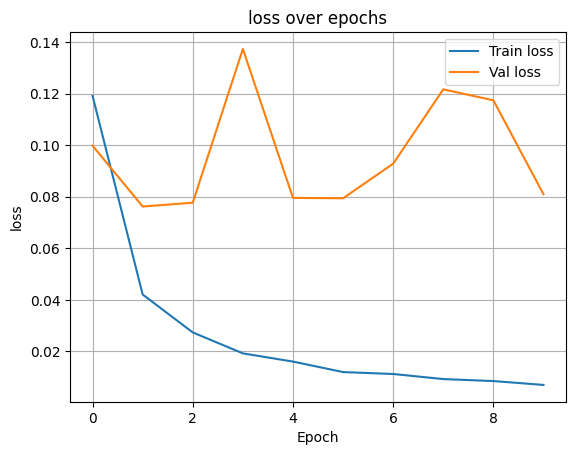

********************************************************************************
***** 	 cnn4_sm 	 *****
********************************************************************************
685/685 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
              precision    recall  f1-score   support

         0.0     0.9944    0.9812    0.9878     18118
         1.0     0.7128    0.8795    0.7874       556
         2.0     0.9658    0.9565    0.9611      1448
         3.0     0.4983    0.9074    0.6433       162
         4.0     0.9944    0.9888    0.9916      1608

    accuracy                         0.9770     21892
   macro avg     0.8331    0.9427    0.8743     21892
weighted avg     0.9817    0.9770    0.9787     21892

Predictions      0    1     2    3     4
187                                     
0.0          17778  186    29  121     4
1.0             57  489     8    1     1
2.0             23   10  1385   26     4
3.0              7    0     8  147     0
4.0             13    1     4    0  15

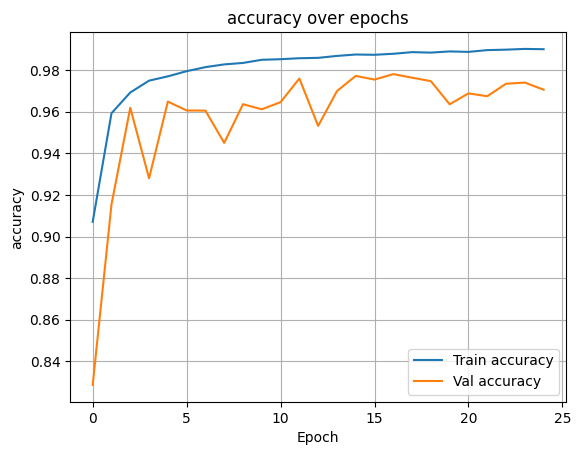

Saved: reports/figures/training_history/cnn4_sm_BS128_loss.png


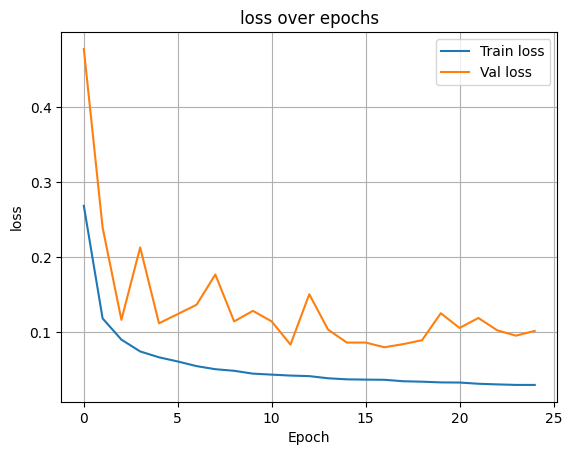

********************************************************************************
***** 	 cnn5_sm 	 *****
********************************************************************************
685/685 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
              precision    recall  f1-score   support

         0.0     0.9912    0.9838    0.9875     18118
         1.0     0.7318    0.8147    0.7711       556
         2.0     0.9350    0.9530    0.9439      1448
         3.0     0.7135    0.7840    0.7471       162
         4.0     0.9725    0.9900    0.9812      1608

    accuracy                         0.9764     21892
   macro avg     0.8688    0.9051    0.8861     21892
weighted avg     0.9775    0.9764    0.9769     21892

Predictions      0    1     2    3     4
187                                     
0.0          17824  162    62   34    36
1.0             92  453     9    1     1
2.0             41    4  1380   16     7
3.0             14    0    20  127     1
4.0             11    0     5    0  15

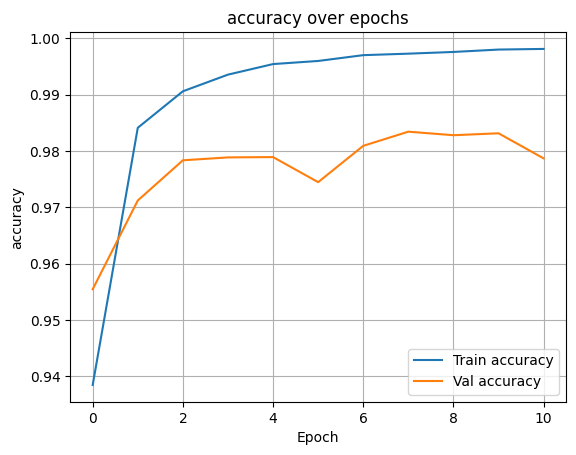

Saved: reports/figures/training_history/cnn5_sm_BS128_loss.png


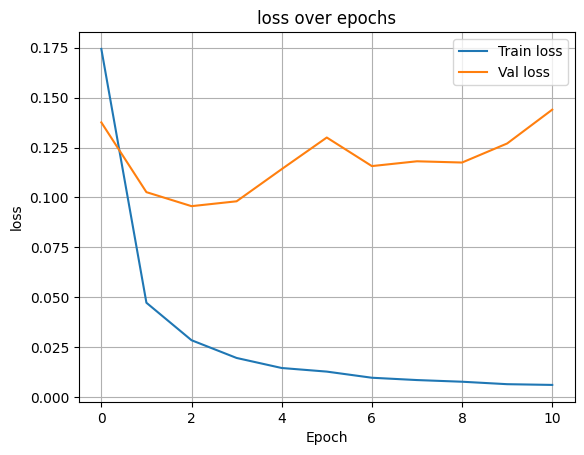

In [6]:
rows = []

for model_name, model in models.items():
    print("*"*80)
    print("*"*5,'\t',model_name,'\t',"*"*5)
    print("*"*80)
    best_model = load_model(f'{OUTPUT_PATH}{model_name}_BS{BATCH_SIZE}.keras')

    with open(f"{OUTPUT_PATH}{model_name}_history.pkl", "rb") as f:
        history = pickle.load(f)
        best_model_history = history.history
    
    #prediction of test data
    test_pred = best_model.predict(X_test_cnn)
    y_pred_class = np.argmax(test_pred, axis=1)
    all_labels = np.unique(y_test)  # ground-truth labels present in test set

    # Force consistent label space for metrics
    print(classification_report(y_test, y_pred_class, digits=4))
    report = classification_report(
        y_test, y_pred_class, labels=all_labels, output_dict=True, zero_division=0
    )

    print(pd.crosstab(y_test, y_pred_class, colnames=['Predictions']))

    # plot and save validation accuracy and validation loss over epochs from history
    plot_training_history(history, "reports/figures/training_history/", f"{model_name}_BS{BATCH_SIZE}")

    accuracy = accuracy_score(y_test, y_pred_class)
    epoch_num = len(history.history['loss'])
    val_loss = best_model_history.get('val_loss')

    row = {
        "time": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "sampling_method": SAMPLING_METHOD,
        "outliers_removed": REMOVE_OUTLIERS,
        "epochs": epoch_num,
        "model": model_name,
        "val_loss": best_model_history['val_loss'][-1],
        "test_accuracy": round(float(accuracy), 4),
        "test_f1_macro": round(float(report["macro avg"]["f1-score"]), 4),
        "test_precision_macro": round(float(report["macro avg"]["precision"]), 4),
        "test_recall_macro": round(float(report["macro avg"]["recall"]), 4),
        "test_f1_weighted": round(float(report["weighted avg"]["f1-score"]), 4),
        "test_precision_weighted": round(float(report["weighted avg"]["precision"]), 4),
        "test_recall_weighted": round(float(report["weighted avg"]["recall"]), 4),
    }
    for lbl in all_labels:
        row[f"test_f1_cls_{int(lbl)}"] = round(float(report[str(lbl)]["f1-score"]), 4)
        row[f"test_precision_cls_{int(lbl)}"] = round(float(report[str(lbl)]["precision"]), 4)
        row[f"test_recall_cls_{int(lbl)}"] = round(float(report[str(lbl)]["recall"]), 4)
        row[f"test_support_cls_{int(lbl)}"] = int(report[str(lbl)]["support"])

    rows.append(row)

In [7]:
df = pd.DataFrame(rows)
os.makedirs(os.path.dirname(results_csv), exist_ok=True)
if os.path.exists(results_csv):
    df.to_csv(results_csv, mode='a', index=False, header=False)
else:
    df.to_csv(results_csv, index=False)